In [1]:
import pandas            as pd
import missingno         as msno
import matplotlib.pyplot as plt

# Data Cleaning

In [2]:
# Import dataset
df_raw  = pd.read_csv("../dat/ship_data.csv")
records = df_raw.shape[0]

# Get columns and data types
print(df_raw.shape)
df_raw.info()

(16248, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16248 entries, 0 to 16247
Data columns (total 26 columns):
Time                                                          16248 non-null int64
Main Engine Fuel Consumption (MT/day)                         16085 non-null float64
Main Engine Using HFO (bool)                                  16085 non-null float64
Main Engine Using MGO (bool)                                  16085 non-null float64
Draft Forward (meters)                                        16085 non-null float64
Draft Aft (meters)                                            16085 non-null float64
Draft Mid-1 (meters)                                          16085 non-null float64
Draft Mid-2 (meters)                                          16085 non-null float64
Shaft Speed (RPM)                                             16085 non-null float64
Shaft Torque (kNm)                                            16085 non-null float64
Shaft Power (kW)               

### Missing Records

Time                                                            0
Main Engine Fuel Consumption (MT/day)                         163
Main Engine Using HFO (bool)                                  163
Main Engine Using MGO (bool)                                  163
Draft Forward (meters)                                        163
Draft Aft (meters)                                            163
Draft Mid-1 (meters)                                          163
Draft Mid-2 (meters)                                          163
Shaft Speed (RPM)                                             163
Shaft Torque (kNm)                                            163
Shaft Power (kW)                                              163
Speed Over Ground (knots)                                     163
Speed Through Water (knots)                                   163
Heading (degrees)                                               8
Rudder Angle (degrees)                                        163
Weather Se

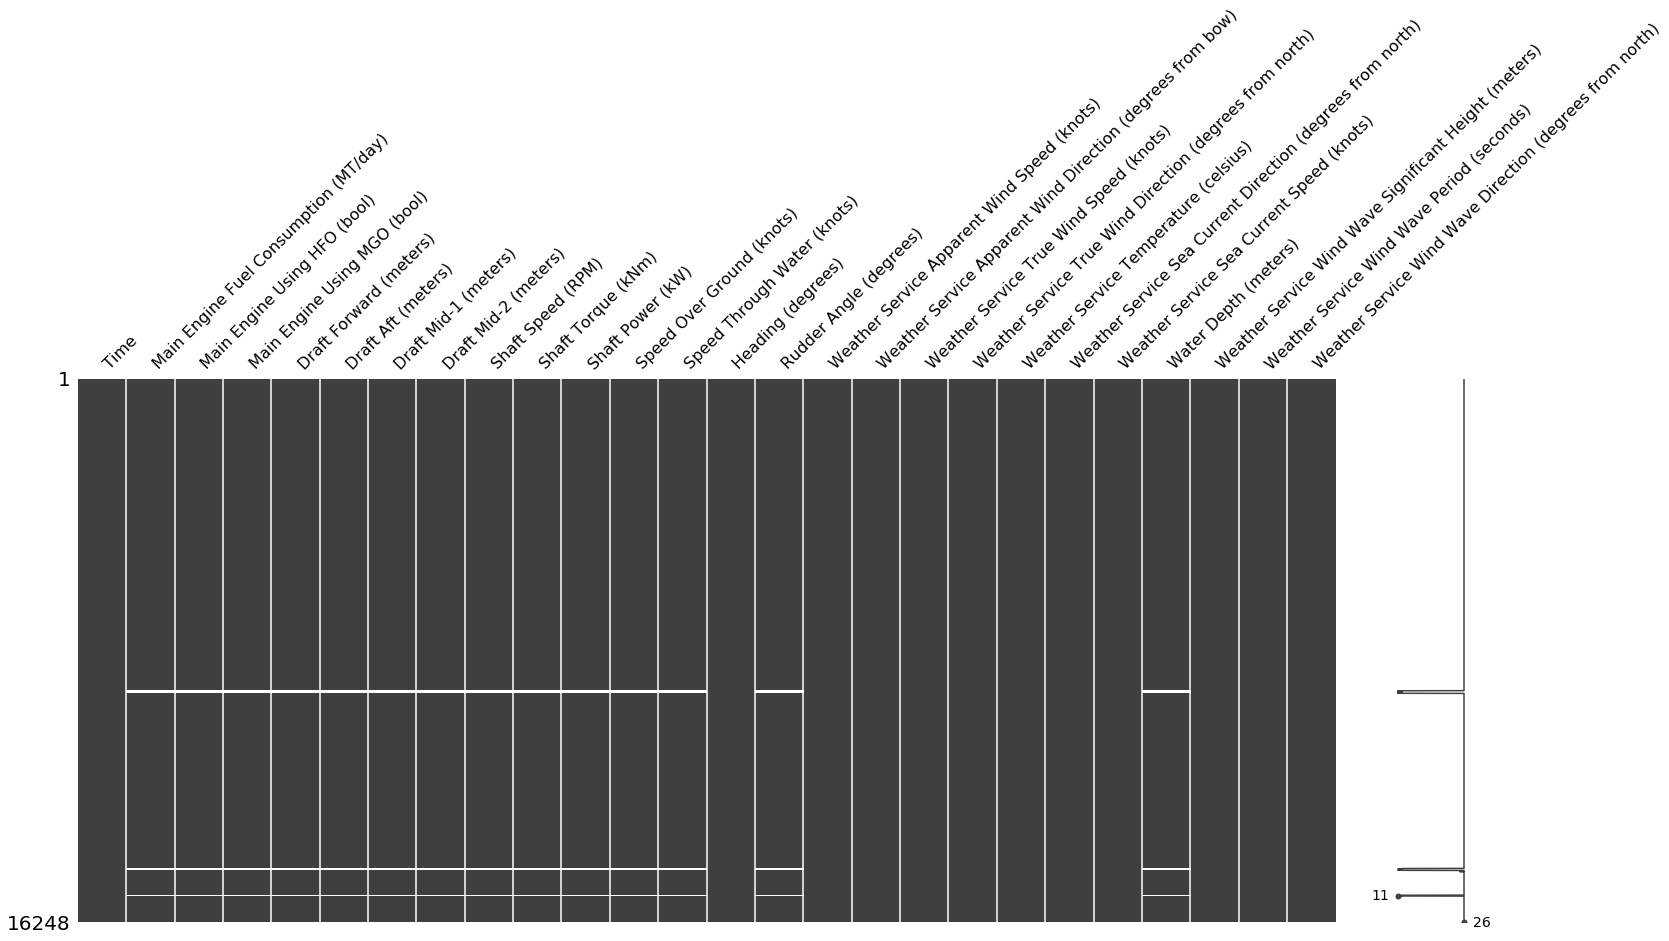

In [3]:
# Check missing values
print(df_raw.isnull().sum())
msno.matrix(df_raw)

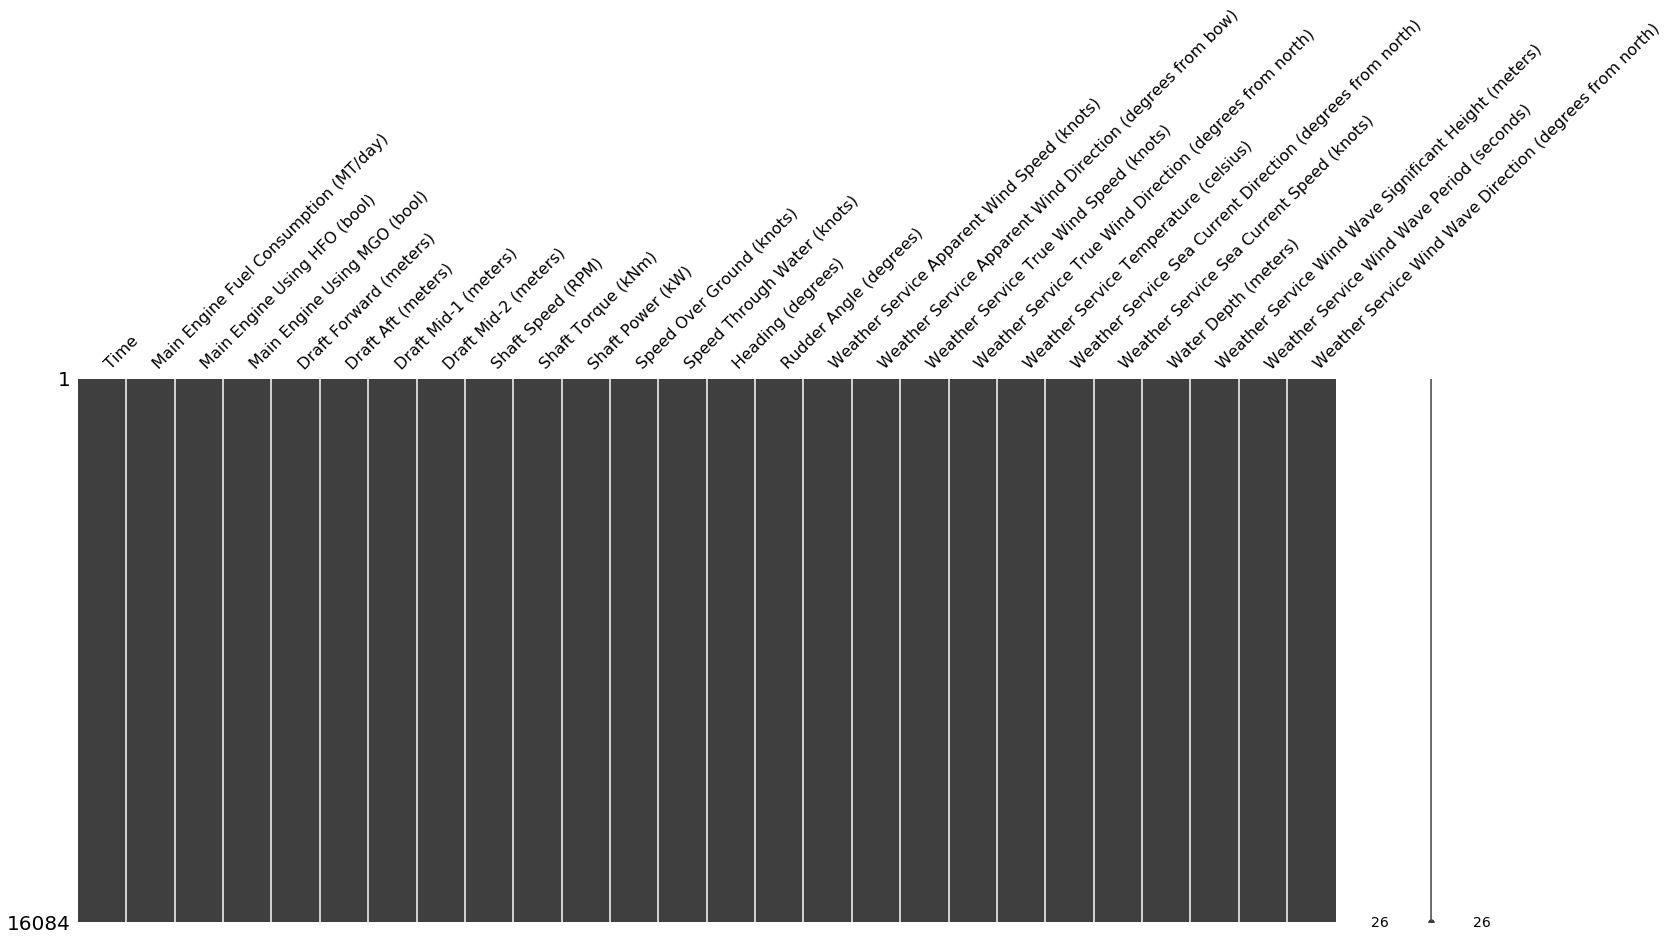

In [4]:
# Drop rows missing target ~ 1% of records
df_mod = df_raw.copy().dropna()
msno.matrix(df_mod)

### Column Sublists

In [5]:
# Create helper sublists of column names
cols_main  = df_mod.columns[0:4]
cols_draft = df_mod.columns[4:8]
cols_shaft = df_mod.columns[8:11]
cols_speed = df_mod.columns[11:15]
cols_wind  = df_mod.columns[15:19]
cols_sea   = df_mod.columns[19:23]
cols_wave  = df_mod.columns[23:26]
df_mod.shape

(16084, 26)

### Time and Main Engine

In [6]:
# Convert Unix time to datetime format
df_mod['Time'] = pd.to_datetime(df_mod['Time'], unit = 's')

# Show head
df_mod[cols_main].head()

,Time,Main Engine Fuel Consumption (MT/day),Main Engine Using HFO (bool),Main Engine Using MGO (bool)
0,2017-07-06 13:15:00,0.0,0.0,0.0
1,2017-07-06 14:00:00,0.0,0.0,0.0
2,2017-07-06 15:00:00,0.0,0.0,0.0
3,2017-07-06 16:00:00,0.0,0.0,0.0
4,2017-07-06 17:00:00,0.0,0.0,0.0


In [7]:
# Get descriptive statistics
df_mod[cols_main].describe()

,Main Engine Fuel Consumption (MT/day),Main Engine Using HFO (bool),Main Engine Using MGO (bool)
count,16084.000000,16084.000000,16084.000000
mean,17.182269,0.816453,0.174122
std,20.758227,0.386674,0.378717
min,-22.565517,0.000000,0.000000
25%,-0.048000,1.000000,0.000000
50%,15.922000,1.000000,0.000000
75%,39.785383,1.000000,0.000000
max,49.090823,1.000000,1.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1aaefc88>,
      dtype=object)

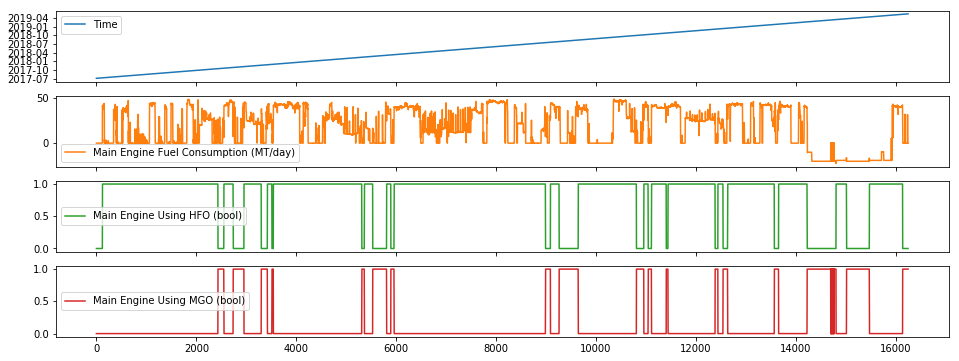

In [8]:
# Plot time series
fig_main, axes_main = plt.subplots(len(cols_main),1, figsize=(16,len(cols_main)*1.5), sharex=True)
df_mod[cols_main].plot(subplots=True, ax=axes_main)

-0.048000     2105
-20.193103     829
-19.200000     617
-0.050483      526
 0.000000      149
Name: Main Engine Fuel Consumption (MT/day), dtype: int64


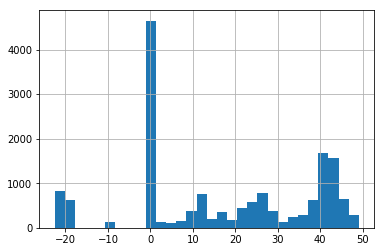

In [9]:
# Investigate negative fuel consumption
print(df_mod[cols_main[1]].value_counts().head())

# Plot frequency distribution
df_mod[cols_main[1]].hist(bins=30)

In [10]:
# Assumption of fuel consumption sensor (target) failure from Feb 19, 2019 to May 1, 2019
cutoff = -5
print(df_mod[df_mod[cols_main[1]] < cutoff].shape)
df_mod[df_mod[cols_main[1]] < cutoff][cols_main].head()

(1580, 26)


,Time,Main Engine Fuel Consumption (MT/day),Main Engine Using HFO (bool),Main Engine Using MGO (bool)
14232,2019-02-19 18:00:00,-10.649842,0.0,1.0
14233,2019-02-19 19:00:00,-10.121793,0.0,1.0
14234,2019-02-19 20:00:00,-10.577492,0.0,1.0
14235,2019-02-19 21:00:00,-10.121793,0.0,1.0
14236,2019-02-19 22:00:00,-10.121793,0.0,1.0


In [11]:
# Drop records with negative fuel consumption ~ 9.7% of records
print(df_mod[df_mod[cols_main[1]] < cutoff].shape[0] / records * 100)
df_mod = df_mod.drop(df_mod[df_mod[cols_main[1]] < cutoff].index).reset_index()
df_mod.shape

9.724273756770065


(14504, 27)

In [12]:
# Correct fuel consumption with offset (0.048 MT/day) and clip remaining lower values
zero_offset          = df_mod[cols_main[1]].value_counts().index[0]
df_mod[cols_main[1]] = df_mod[cols_main[1]] - zero_offset
df_mod[cols_main[1]] = df_mod[cols_main[1]].clip(lower=0)
df_mod[cols_main[1]].value_counts().sort_index().head()

0.000000    3163
0.000017       1
0.000018       1
0.000021       1
0.000026       1
Name: Main Engine Fuel Consumption (MT/day), dtype: int64

In [36]:
# Revert HFO and MGO to booleans (unbalanced value counts)
print(df_mod[cols_main[2]].value_counts())
df_mod[cols_main[2]] = df_mod[cols_main[2]].astype('int64')
df_mod[cols_main[3]] = df_mod[cols_main[3]].astype('int64')

1.000000    12456
0.000000     2019
0.583333        4
0.083333        3
0.250000        3
0.666667        3
0.750000        2
0.083333        2
0.500000        2
0.166667        2
0.916667        1
0.833333        1
0.416667        1
0.833333        1
0.333333        1
0.583333        1
0.416667        1
0.333333        1
Name: Main Engine Using HFO (bool), dtype: int64


In [37]:
# Drop 
df_mod['Fuel'] = df_mod[cols_main[2]] + df_mod[cols_main[3]]
df_mod['Fuel'].value_counts()

1    14323
0      181
Name: Fuel, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a199f2da0>,
      dtype=object)

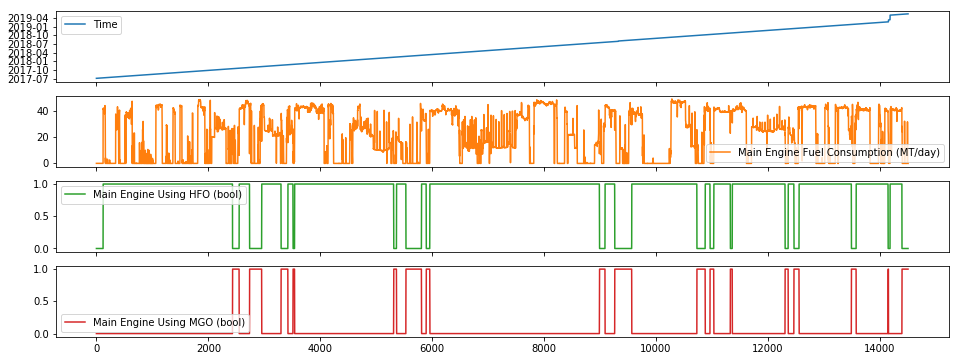

In [15]:
# Plot time series
fig_main, axes_main = plt.subplots(len(cols_main),1, figsize=(16,len(cols_main)*1.5), sharex=True)
df_mod[cols_main].plot(subplots=True, ax=axes_main)

In [16]:
df_mod.reset_index().tail()

,level_0,index,Time,Main Engine Fuel Consumption (MT/day),Main Engine Using HFO (bool),Main Engine Using MGO (bool),Draft Forward (meters),Draft Aft (meters),Draft Mid-1 (meters),Draft Mid-2 (meters),...,Weather Service Apparent Wind Direction (degrees from bow),Weather Service True Wind Speed (knots),Weather Service True Wind Direction (degrees from north),Weather Service Temperature (celsius),Weather Service Sea Current Direction (degrees from north),Weather Service Sea Current Speed (knots),Water Depth (meters),Weather Service Wind Wave Significant Height (meters),Weather Service Wind Wave Period (seconds),Weather Service Wind Wave Direction (degrees from north)
14499,14499,16243,2019-05-14 11:00:00,0.0,0.0,1.0,8.726591,8.777207,8.753742,8.863745,...,0.000000e+00,0.0,180.0,0.0,0.0,0.0,14.995446,0.0,0.0,0.0
14500,14500,16244,2019-05-14 12:00:00,0.0,0.0,1.0,8.714152,8.775698,8.761056,8.857463,...,-2.842171e-14,0.0,180.0,0.0,0.0,0.0,15.000000,0.0,0.0,0.0
14501,14501,16245,2019-05-14 13:00:00,0.0,0.0,1.0,8.639662,8.829447,8.787306,8.828243,...,0.000000e+00,0.0,180.0,0.0,0.0,0.0,15.000000,0.0,0.0,0.0
14502,14502,16246,2019-05-14 14:00:00,0.0,0.0,1.0,8.706126,8.857078,8.882388,8.830731,...,5.846950e+00,0.0,180.0,0.0,0.0,0.0,14.807075,0.0,0.0,0.0
14503,14503,16247,2019-05-14 14:50:00,0.0,0.0,1.0,8.727579,8.958171,8.947866,8.887519,...,-7.107748e+00,0.0,180.0,0.0,0.0,0.0,14.000000,0.0,0.0,0.0


### Draft

In [17]:
# Show head
df_mod[cols_draft].head()

,Draft Forward (meters),Draft Aft (meters),Draft Mid-1 (meters),Draft Mid-2 (meters)
0,0.0,0.0,0.0,11.497695
1,0.0,0.0,0.0,11.509352
2,0.0,0.0,0.0,11.531678
3,0.0,0.0,0.0,11.545624
4,0.0,0.0,0.0,11.549795


In [18]:
# Get descriptive statistics
df_mod[cols_draft].describe()

,Draft Forward (meters),Draft Aft (meters),Draft Mid-1 (meters),Draft Mid-2 (meters)
count,14504.000000,14504.000000,14504.000000,14504.000000
mean,7.959370,9.451760,8.707609,8.813320
std,2.629248,1.920433,2.235163,2.090242
min,0.000000,0.000000,0.000000,5.681231
25%,5.767478,7.926772,6.818414,6.845618
50%,7.120002,8.768419,7.944510,8.232988
75%,10.690962,11.497399,11.084572,11.189153
max,13.136587,12.589208,12.076237,12.127948


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1c32a8d0>,
      dtype=object)

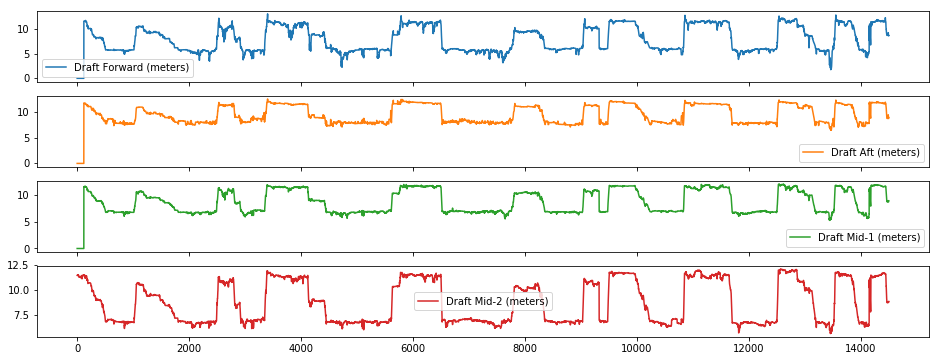

In [19]:
# Plot time series
fig_draft, axes_draft = plt.subplots(len(cols_draft),1, figsize=(16,len(cols_draft)*1.5), sharex=True)
df_mod[cols_draft].plot(subplots=True, ax=axes_draft)

### Shaft

In [20]:
# Show head
df_mod[cols_shaft].head()

,Shaft Speed (RPM),Shaft Torque (kNm),Shaft Power (kW)
0,84.878837,1013.631639,0.0
1,84.868300,1004.244559,0.0
2,84.874972,1003.751648,0.0
3,84.867446,1010.716545,0.0
4,84.864535,1013.179696,0.0


In [21]:
# Get descriptive statistics
df_mod[cols_shaft].describe()

,Shaft Speed (RPM),Shaft Torque (kNm),Shaft Power (kW)
count,14504.000000,14504.000000,14504.000000
mean,50.893528,578.727517,4754.568061
std,36.922832,449.229000,4090.802725
min,-7.110332,-0.001360,0.000000
25%,0.000000,7.333179,6.847132
50%,69.245264,710.969613,4918.171782
75%,85.509709,1031.272189,9213.285963
max,88.959431,1206.091541,11150.041983


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d2f09b0>,
      dtype=object)

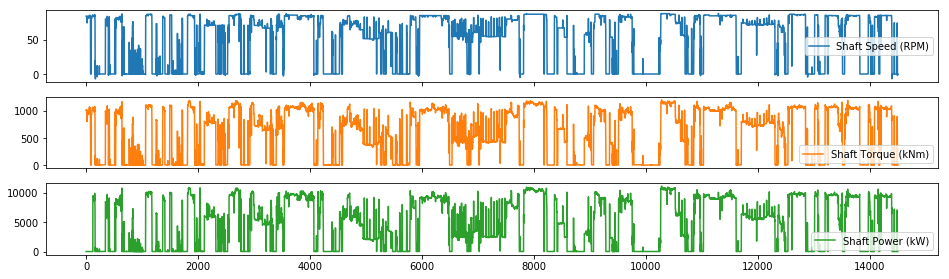

In [22]:
# Plot time series
fig_shaft, axes_shaft = plt.subplots(len(cols_shaft),1, figsize=(16,len(cols_shaft)*1.5), sharex=True)
df_mod[cols_shaft].plot(subplots=True, ax=axes_shaft)

### Speed and Heading

In [23]:
# Show head
df_mod[cols_speed].head()

,Speed Over Ground (knots),Speed Through Water (knots),Heading (degrees),Rudder Angle (degrees)
0,15.463448,15.607449,167.741687,358.025169
1,15.744354,15.776289,168.034239,357.967447
2,15.939796,15.707046,152.496507,358.605730
3,16.135230,15.723442,128.601049,358.864694
4,16.176168,15.692471,107.945165,358.951153


In [24]:
# Get descriptive statistics
df_mod[cols_speed].describe()

,Speed Over Ground (knots),Speed Through Water (knots),Heading (degrees),Rudder Angle (degrees)
count,14504.000000,14504.000000,14504.000000,14504.000000
mean,9.348965,9.260904,185.850736,324.827559
std,6.619858,6.605865,102.156691,103.737147
min,0.000000,-0.812132,-164.643903,0.000000
25%,0.434405,0.401676,89.873842,357.463360
50%,12.506260,12.574411,214.769251,358.596717
75%,15.201381,15.182432,276.011206,359.108832
max,19.844884,17.186902,359.824424,359.999195


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a19b6b550>,
      dtype=object)

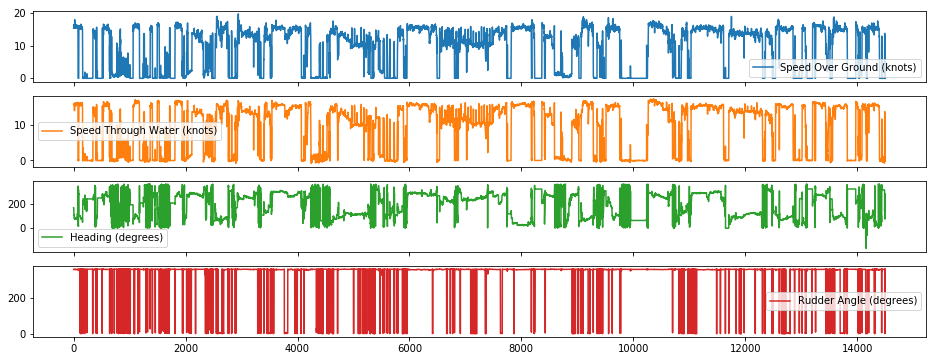

In [25]:
# Plot time series
fig_speed, axes_speed = plt.subplots(len(cols_speed),1, figsize=(16,len(cols_speed)*1.5), sharex=True)
df_mod[cols_speed].plot(subplots=True, ax=axes_speed)

### Wind

In [26]:
# Show head
df_mod[cols_wind].head()

,Weather Service Apparent Wind Speed (knots),Weather Service Apparent Wind Direction (degrees from bow),Weather Service True Wind Speed (knots),Weather Service True Wind Direction (degrees from north)
0,10.562150,20.425315,6.675341,314.224434
1,11.235851,23.426522,7.034934,308.615477
2,9.877019,22.396432,7.778714,303.563221
3,7.794503,8.588757,8.508143,300.737464
4,8.224946,-15.548513,8.541664,302.903406


In [27]:
# Get descriptive statistics
df_mod[cols_wind].describe()

,Weather Service Apparent Wind Speed (knots),Weather Service Apparent Wind Direction (degrees from bow),Weather Service True Wind Speed (knots),Weather Service True Wind Direction (degrees from north)
count,14504.000000,14504.000000,14504.000000,14504.000000
mean,14.543335,3.357670,11.757960,187.534697
std,8.581527,114.664273,6.395980,113.706643
min,0.000000,-358.561592,0.000000,0.000568
25%,7.811818,-41.119467,7.055350,78.534037
50%,13.112162,-1.602280,11.001944,196.579960
75%,20.127285,37.668798,15.635964,293.475786
max,51.955335,414.254017,40.845838,359.997076


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e429f28>,
      dtype=object)

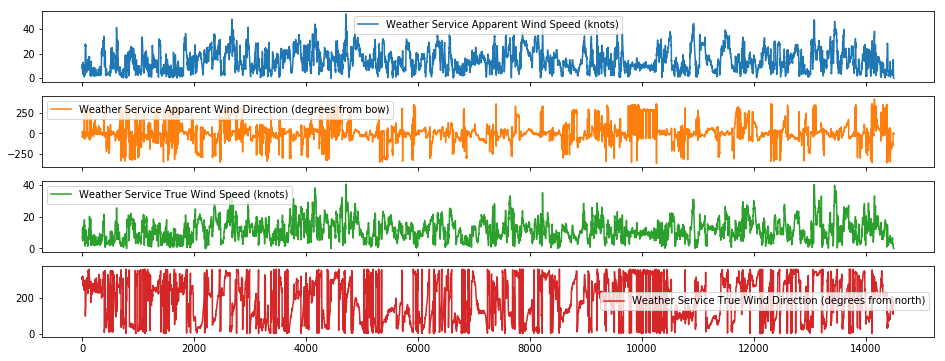

In [28]:
# Plot time series
fig_wind, axes_wind = plt.subplots(len(cols_wind),1, figsize=(16,len(cols_wind)*1.5), sharex=True)
df_mod[cols_wind].plot(subplots=True, ax=axes_wind)

### Sea

In [29]:
# Show head
df_mod[cols_sea].head()

,Weather Service Temperature (celsius),Weather Service Sea Current Direction (degrees from north),Weather Service Sea Current Speed (knots),Water Depth (meters)
0,20.283071,254.033533,0.070896,0.0
1,20.360865,323.890575,0.006596,0.0
2,20.534437,22.703059,0.027087,0.0
3,20.641539,347.948256,0.034555,0.0
4,20.662176,217.495117,0.029501,0.0


In [30]:
# Get descriptive statistics
df_mod[cols_sea].describe()

,Weather Service Temperature (celsius),Weather Service Sea Current Direction (degrees from north),Weather Service Sea Current Speed (knots),Water Depth (meters)
count,14504.000000,14504.000000,14504.000000,14504.000000
mean,21.971244,115.970047,0.269815,18.916650
std,12.263289,116.152028,0.406530,46.750853
min,-273.150000,0.000000,0.000000,0.000000
25%,18.047596,0.000000,0.000000,0.000000
50%,23.916866,84.172646,0.137029,0.000000
75%,27.063633,213.686757,0.352161,9.384601
max,52.559168,359.999716,3.184603,326.803230


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ebbfef0>,
      dtype=object)

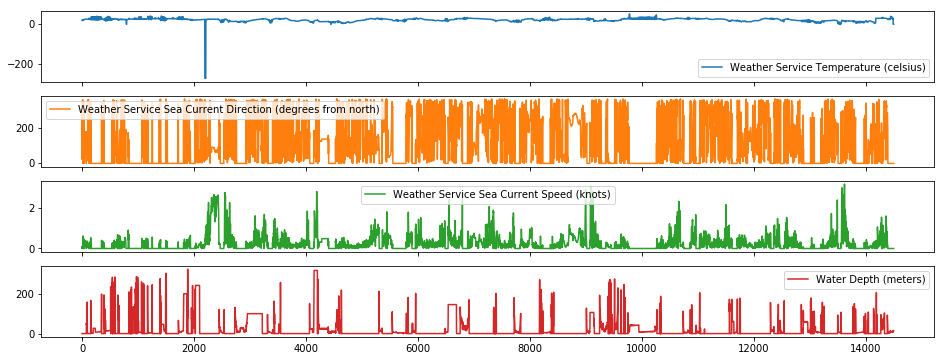

In [31]:
# Plot time series
fig_sea, axes_sea = plt.subplots(len(cols_sea),1, figsize=(16,len(cols_sea)*1.5), sharex=True)
df_mod[cols_sea].plot(subplots=True, ax=axes_sea)

### Wave

In [32]:
# Show head
df_mod[cols_wave].head()

,Weather Service Wind Wave Significant Height (meters),Weather Service Wind Wave Period (seconds),Weather Service Wind Wave Direction (degrees from north)
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [33]:
# Get descriptive statistics
df_mod[cols_wave].describe()

,Weather Service Wind Wave Significant Height (meters),Weather Service Wind Wave Period (seconds),Weather Service Wind Wave Direction (degrees from north)
count,14504.000000,14504.000000,14504.000000
mean,0.311126,1.226032,32.867978
std,0.797772,2.754324,81.828768
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,6.323284,13.873590,356.882793


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a205a7eb8>,
      dtype=object)

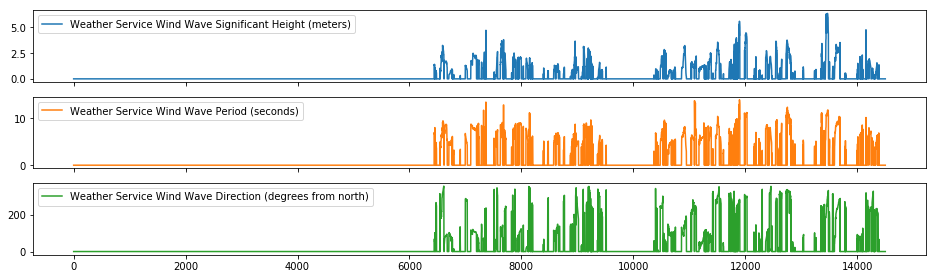

In [34]:
# Plot time series
fig_wave, axes_wave = plt.subplots(len(cols_wave),1, figsize=(16,len(cols_wave)*1.5), sharex=True)
df_mod[cols_wave].plot(subplots=True, ax=axes_wave)

# 1. Machine Learning Model

# 2. Speed Scores

# 3. Report

# 4. Sensor Drift